# **Incremental Forecast generation with MLForecast**

This tutorial provides a practical framework for developing **incremental forecasting systems** using Nixtla’s `MLForecast`. It walks through the full process of building scalable time series pipelines-from baseline model training to monthly incremental updates-illustrating how `update()` enables efficient, real-time forecast refreshes without full retraining. The focus is on designing **sustainable, production-grade forecasting workflows** that balance speed, adaptability, and long-term accuracy.

## **Table of Contents**

1. Introduction
2. Why Incremental Forecasting Matters 
3. Why You Should Not Retrain at Every Step
4. When Full Retraining Becomes Necessary
5. A Hybrid Cadence for Reliable Forecasting Pipelines  
6. Model Design and Implementation Flow 
7. Comparing Incremental Updates and Full Retraining
8. Visual Analysis of Forecast Behavior
9. Conclusion


## **Introduction**

When a forecasting system goes live, the flow of data doesn’t stop. Each month - or even each week - new observations arrive, and decision-makers expect your forecasts to adjust in real time. Yet, retraining the entire model every time new data comes in is often the default reaction. It seems simple, but it’s computationally expensive, time-consuming, and can introduce instability into production workflows.

This is where incremental forecasting becomes essential. Instead of retraining from scratch, we can incrementally update the model to reflect the latest data while preserving its learned patterns and parameters. In Nixtla’s `MLForecast`, the `update()` method provides this capability by allowing a trained forecasting object to absorb new observations without retraining the underlying estimator. It extends the historical window for each series, recalculates lag and date features, and ensures that subsequent forecasts are generated using the most recent actuals.

## **Why You Shouldn’t Retrain Every Time**

Once your forecasting system is operational, new data becomes a constant. Each cycle - be it daily, weekly, or monthly - brings new observations that reflect the latest market conditions. The instinctive reaction is to retrain the entire model whenever new data arrives, under the assumption that a fresh model guarantees higher accuracy. In practice, however, **frequent retraining is neither efficient nor necessary**.

Retraining a global model across thousands of time series is computationally expensive and can introduce instability into production pipelines. Each retrain recalculates lag features, re-splits data, re-fits hyperparameters, and may slightly shift model weights due to stochastic effects, creating subtle variations in forecast outputs that can confuse downstream systems or decision-makers. Moreover, most new observations tend to reinforce existing patterns rather than alter them drastically.

The **incremental update** approach offers a more robust alternative. Instead of discarding the existing model, MLForecast’s `update()` method allows you to append new observations to the existing historical window. It recalculates lag, lag_transforms, and date features while keeping the learned model parameters fixed. This ensures that your forecasts stay aligned with the most recent actuals without triggering a full retraining cycle. The table below summarizes the difference between Retraining the model and Incremental Learning.


| **Concern**          | **Retraining Every Month**                                 | **Using `update()` (Incremental Learning)**                |
|----------------------|-------------------------------------------------------------|-------------------------------------------------------------|
| **Compute Cost**     | High (retraining models for all SKUs consumes significant compute) | Minimal (only updates incremental weights or new samples)   |
| **Speed**            | Slow (full retraining can take hours for large datasets)    | Fast (updates often complete in seconds or minutes, even for many SKUs) |
| **Model Stability**  | May introduce noise or instability between training runs     | Maintains consistent learned structure; less susceptible to random noise |
| **Versioning Overhead** | Multiple model artifacts; difficult to track and manage     | Single stable model with incremental updates; simpler to manage |
| **Operational Risk** | Errors can propagate during frequent retraining cycles       | Controlled, gradual updates reduce sudden failures           |


## **When to Retrain Anyway**

Incremental updates are powerful, but they are not a permanent substitute for model retraining. Over time, even the most robust forecasting systems experience **concept drift** - subtle or abrupt changes in the underlying data-generating process. When this happens, the relationships your model once learned no longer represent reality. In other words, the past stops being a reliable guide to the future.

Retraining becomes necessary when the environment changes in ways that cannot be captured by simply appending new observations. Some common triggers include:

#### 1. Structural breaks in the data

Events such as product rebranding, changes in packaging, or shifts in demand patterns can cause discontinuities in historical trends. These “structural breaks” disrupt the temporal consistency that incremental updates rely on. A retraining cycle helps the model recalibrate to the new baseline.


**How to identify structural changes**

| Method Category | Technique | How it Works | When to Use |
|-----------------|-----------|--------------|-------------|
| **Classical structural break detection** | CUSUM, Bai Perron tests, Chow test | Detects statistically significant breaks in mean, variance, trend, or regression relationships by comparing parameter stability across segments | When regime changes are suspected due to events such as rebranding, packaging changes, policy interventions, or known breakpoint shifts |
| **Residual and error diagnostics** | Residual pattern analysis, rolling RMSE or RMSSE | Identifies abrupt structural changes by detecting persistent bias, variance jumps, new autocorrelation patterns, or sudden degradation in performance metrics | When the model begins underpredicting or overpredicting in a consistent pattern or when accuracy drops after a structural shift |
| **Machine learning based structural detection** | Drift classification models | Uses classification to distinguish between pre-event and post-event data, revealing multidimensional structural differences | When breaks are subtle, involve multiple features, or are not well captured by classical statistical tests |
| **Domain driven indicators** | Business event logs, operational change tracking | Links structural changes to real business events such as assortment updates, supply chain disruptions, pricing regime shifts, or major operational interventions | When the structural break is caused by an external or managerial action rather than intrinsic time-series behaviour |



#### 2. Distributional or seasonal drift

If the statistical properties of the series - mean, variance, or seasonal amplitudes - start deviating consistently from past patterns, your lag-based features become less predictive. 

**How to identify distributional or seasonal drift**

| Method Category | Technique | What it Detects | When to Use |
|-----------------|-----------|------------------|-------------|
| **Distributional drift detection** | KS test, PSI, Jensen Shannon divergence, KL divergence | Detects shifts in mean, variance, shape, or overall distribution differences between historical and recent windows | When monitoring for gradual distributional drift in production systems |
| **Residual and error diagnostics** | Rolling RMSSE, windowed performance metrics, residual distribution comparison | Detects sustained performance degradation or changes in residual bias, variance, or autocorrelation | When accuracy declines or residual patterns indicate emerging drift |
| **Seasonality drift detection** | STL or MSTL seasonal comparison, seasonal correlation checks, spectral density analysis, seasonal strength metrics | Detects changes in seasonal amplitude, timing, periodicity, or variance explained by seasonality | When intra year seasonality evolves due to behavior, climate, or market changes |
| **Machine learning based drift detection** | Drift classification model | Detects subtle or multidimensional drift by classifying old vs new windows | When drift affects multiple features simultaneously and is not captured by univariate tests |



#### 3. Changes in exogenous features

When the relationship between the target and external drivers changes, the model’s learned dependencies no longer reflect how the real world behaves. These changes often arise from broader business or environmental shifts rather than from the time series itself. For example, sudden changes in import tariffs can make certain products more expensive and reduce sensitivity to discounts, altering long-standing price–demand relationships. The COVID-19 pandemic is another well known example where mobility restrictions, work-from-home adoption, and shifts in consumer priorities changed the way promotions, holidays, and even weather patterns influenced demand. Fuel price spikes can change commuting behaviour and affect categories like ready-to-eat foods, travel accessories, or home improvement. Unexpected supply shortages can change how customers respond to stockouts or substitute products. Even store refurbishments, new competitor entries, or changes in brand positioning can shift the effectiveness of promotions or alter the response to price changes. In all these scenarios, the external features have not simply drifted in value; the way they influence demand has changed. Models relying on outdated relationships need retraining to correctly learn the new dependency structure.

#### 4. Model degradation in monitoring metrics

A steady rise in forecast error such as RMSSE or MAPE across a meaningful portion of the portfolio is one of the clearest signals that incremental updates are no longer sufficient. In practice, this degradation is detected through rolling or windowed error tracking, residual stability checks, horizon specific error monitoring, and cohort level breakdowns, all of which were discussed in earlier sections. When these monitoring signals begin to trend upward consistently, or when residuals show persistent bias or variance inflation, it indicates that the model is drifting away from the underlying data generating process. At this point, incremental updates can no longer correct the misalignment and a full retraining cycle becomes necessary to restore performance stability.



#### 5. Major business or market shifts

Major business or market shifts can reshape demand patterns so abruptly that previously learned temporal relationships no longer hold. External shocks such as sudden supply chain disruptions, unexpected policy changes, or rapid demand surges create new regimes that the model has never seen before. Examples include widespread stockouts during global logistics delays, regulatory changes affecting product availability, or short-term spikes in demand triggered by festivals, weather anomalies, or viral social trends. As discussed earlier, these shifts often operate outside the time series itself and override the stability that incremental updates rely on. When such events realign consumer behaviour or operational constraints, a full retraining cycle becomes necessary to ensure the model adapts to the new environment.

## **A Hybrid Cadence for Sustainable Forecasting**


Retraining and updating are not competing strategies - they’re complementary. In a well-engineered forecasting pipeline, the two work together to balance **adaptability**, **efficiency**, and **stability**. This balanced cadence ensures your model evolves with data drift while avoiding unnecessary computational overhead.

A **hybrid cadence** combines three operational layers:

#### 1. Routine Incremental Updates (Short-Term Adaptation)

Use MLForecast’s `update()` method every time new data arrives - typically weekly or monthly.
This keeps forecasts current by recalculating lag and date features using the latest observations, without retraining the model.

* **Objective:** Maintain freshness of forecasts
* **Cost:** Minimal (light computation)
* **When to use:** After each data ingestion cycle

#### 2. Scheduled Retraining (Periodic Refresh)

Perform full model retraining at regular intervals - for instance, quarterly or semi-annually.
This refreshes feature relationships, captures gradual drift, and resets model parameters to reflect long-term trends.

* **Objective:** Recalibrate the model to evolving seasonal or macro patterns
* **Cost:** Moderate to high (training time and resource usage)
* **When to use:** On a fixed calendar schedule or after major seasonal transitions

#### 3. Drift-Triggered Retraining (Event-Based Correction)

Deploy monitoring scripts that track forecast accuracy (e.g., RMSSE, MAPE, WAPE) and detect statistical drift using tools such as the Kolmogorov–Smirnov test or rolling error windows.
If accuracy degrades beyond a defined threshold, initiate an unscheduled retrain.

* **Objective:** Respond to sudden or unanticipated changes
* **Cost:** High but justified by regained accuracy
* **When to use:** When metrics indicate model degradation or feature distribution shifts



#### Quantitative Validation

To evaluate the effectiveness of this cadence, compare update-only vs. retrain strategies using MLForecast’s `cross_validation()`:

* `refit=False` simulates incremental updates (trained once, updated continuously)
* `refit=True` simulates retraining at each historical window
  If `refit=True` consistently outperforms `refit=False`, it signals that drift is significant and retraining yields real gains.



#### Why This Matters

This cadence matters because forecasting systems fail silently when they rely on only one mechanism of adaptation. Incremental updates alone cannot correct for long-term drift, and full retraining alone cannot deliver the responsiveness modern pipelines require. By combining both, you create a system that stays fresh in the short term, stable in the long term, and resilient when unexpected changes occur. It ensures that the model not only keeps pace with new data but also remains aligned with the deeper structural patterns that drive forecasting accuracy. In practice this means fewer operational surprises, fewer degradations that go unnoticed, and forecasts that remain dependable even as the business and the environment around it evolve

In essence, **incremental updates keep your model agile; retraining keeps it honest.**


## **Code Implementation Overview**

#### **Installing `mlforecast` and Required Libraries**

Before we dive into incremental forecasting, let’s set up the environment by installing all necessary dependencies. We’ll use **Nixtla’s `mlforecast`**, along with common Python libraries for data handling and visualization. You can open it in colab in this [link](https://colab.research.google.com/github/Satyajit-Chaudhuri/incremental_updates_time_series/blob/main/incremental_forecasting.ipynb).

> 💡 *Tip:* If you’re running this in Google Colab or a fresh environment, it’s a good idea to restart the kernel after installation to ensure all dependencies are properly loaded.


In [1]:
!pip install mlforecast datasetsforecast s3fs xgboost -q

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import xgboost as xgb
import pandas as pd
from mlforecast import MLForecast
from datasetsforecast.m3 import M3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlforecast.lag_transforms import (ExpandingMean, ExpandingStd, ExpandingMin, ExpandingMax, 
                                       RollingMean, RollingStd, RollingMin, RollingMax,ExponentiallyWeightedMean)
from functools import partial
import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

## **Loading the M3 Dataset**

For this demonstration, we’ll use the **M3 forecasting competition dataset**, a widely used benchmark for evaluating time series models.  
Specifically, we’ll focus on the **`M1` series** from the **Monthly (M) group**.

The M3 dataset provides multiple time series across different frequencies -*Yearly, Quarterly, Monthly, and Others*.  
By selecting one unique identifier (`unique_id = 'M1'`), we can visualize and test how incremental forecasting behaves on a single, interpretable time series.

> 📘 *Note:* The dataset is loaded using Nixtla’s `datasetsforecast` package, which automatically structures the data in the expected format for MLForecast - columns `unique_id`, `ds` (date), and `y` (target value).


In [4]:
# Load M3 data (e.g., monthly frequency)
Y_df, X_df, S_df = M3.load(directory='./', group='Monthly')

# Filter for the specified unique_id
select = ['M1']
df_select = Y_df[Y_df['unique_id'].isin(select)].copy()


# Convert 'Date' column to datetime in the original filtered dataframe
df_select['ds'] = pd.to_datetime(df_select['ds'])

# Sort by unique_id and Date to ensure correct slicing
df_select = df_select.sort_values(by=['unique_id', 'ds']).reset_index(drop=True)

print("Preview of df_select")
print("Top 5 rows:")
display(df_select.head())

print("\nShape of df_select")
print(f"Rows: {df_select.shape[0]}")
print(f"Columns: {df_select.shape[1]}")

Preview of df_select
Top 5 rows:


,unique_id,ds,y
0,M1,1990-01-31,2640.0
1,M1,1990-02-28,2640.0
2,M1,1990-03-31,2160.0
3,M1,1990-04-30,4200.0
4,M1,1990-05-31,3360.0



Shape of df_select
Rows: 68
Columns: 3


#### **Defining the Simulation Scenario**

To replicate a **real-world production forecasting setup**, we’ll simulate how forecasts evolve as new data arrives over time, without retraining the model. This helps us understand how Nixtla’s `update()` method can efficiently keep forecasts current in a live environment.

Here’s how we’ll structure the simulation:

- Data **from 1991-06-30 to 1994-05-31** serves as the **baseline training period (Month 0)** - the last available data before the model is deployed.
- We then simulate **three consecutive production updates**, where new observations gradually arrive:
  - **Month 1:** Includes actuals for  *1994-06-30*  
  - **Month 2:** Includes actuals for *1994-07-31*  
  - **Month 3:** Includes actuals for *1994-08-31*  

At each step, the model will be **incrementally updated** using the `update()` method, allowing it to absorb new observations, recompute lags and date features, and produce refreshed forecasts without undergoing a full retraining cycle.



In [5]:
# ------------------------------------
# Select the last 51 data points from df_select
# ------------------------------------
data = df_select.tail(51)

# From these 51 points:
# - Use the first 36 data points for initial model training (Month 0)
# - Reserve the next 3 data points as sequential "new data arrivals"
train_month_zero = data.head(36)
new_data_all = data.iloc[36:39]

# ------------------------------------
# Split the 3 new months into separate DataFrames to simulate data arriving one month at a time
# ------------------------------------
new_data_month_one   = new_data_all.iloc[0:1]
new_data_month_two   = new_data_all.iloc[1:2]
new_data_month_three = new_data_all.iloc[2:3]

# ------------------------------------
# Show the original training and new-data splits
# ------------------------------------
print("Preview - Train DataFrame (Month 0 - initial training window):")
display(train_month_zero.head(5))

print("="*60)
print("\nNew Data Month One (to arrive after Month 0):")
display(new_data_month_one)

# ------------------------------------
# Construct cumulative training sets by concatenation for showing the full training example
# - train_month_one  = train_month_zero  + new_data_month_one
# - train_month_two  = train_month_one   + new_data_month_two
# - train_month_three= train_month_two   + new_data_month_three
# We concatenate in chronological order so time index remains increasing.
# ------------------------------------
train_month_one    = pd.concat([train_month_zero, new_data_month_one], ignore_index=True)
train_month_two    = pd.concat([train_month_one,  new_data_month_two], ignore_index=True)
train_month_three  = pd.concat([train_month_two,  new_data_month_three], ignore_index=True)

print("="*60)
print("\nPreview - train_month_one (last rows):")
display(train_month_one.tail(5))


# ------------------------------------
# Create rolling test windows for evaluation
# ------------------------------------
test_month_zero  = data.iloc[36:48]
test_month_one   = data.iloc[37:49]
test_month_two   = data.iloc[38:50]
test_month_three = data.iloc[39:51]

# ------------------------------------
# Also display the test windows used for evaluation (as before)
# ------------------------------------
print("="*60)
print("\nPreview - Test Window - Month 0 (after initial training):")
display(test_month_zero.head(5))




Preview - Train DataFrame (Month 0 - initial training window):


,unique_id,ds,y
17,M1,1991-06-30,2520.0
18,M1,1991-07-31,9000.0
19,M1,1991-08-31,2640.0
20,M1,1991-09-30,3120.0
21,M1,1991-10-31,2880.0



New Data Month One (to arrive after Month 0):


,unique_id,ds,y
53,M1,1994-06-30,1920.0



Preview - train_month_one (last rows):


,unique_id,ds,y
32,M1,1994-02-28,2400.0
33,M1,1994-03-31,2280.0
34,M1,1994-04-30,480.0
35,M1,1994-05-31,5040.0
36,M1,1994-06-30,1920.0



Preview - Test Window - Month 0 (after initial training):


,unique_id,ds,y
53,M1,1994-06-30,1920.0
54,M1,1994-07-31,840.0
55,M1,1994-08-31,2520.0
56,M1,1994-09-30,1560.0
57,M1,1994-10-31,1440.0


#### **Model specification - XGBoost with lags and lag_transforms**

For this demonstration we use XGBoost Regressor together with a small set of lag features and lag_transforms. The goal is to keep the model simple and interpretable while preserving enough temporal information to produce reliable incremental forecasts. In the next block we define the complete forecasting setup for Month Zero. We create an MLForecast object that includes the XGBoost Regressor, the time frequency of the series and a structured set of lag features and lag based statistical transforms. The same block also defines a compact evaluation function that uses `utilsforecast` to merge predictions with the test set and compute **MAE** and **RMSE**. This keeps the evaluation process consistent for all forecasting stages that follow.

In [ ]:
# Load your data (must have columns: unique_id, ds, y)
df = train_month_zero

# Initialize the MLForecast object with model, frequency and feature settings
fcst = MLForecast(
    models=xgb.XGBRegressor(verbosity=0, random_state=5),
    freq='ME',
    lags=[1, 2, 3, 4, 6, 12],  # added more lags
    lag_transforms={
        1: [ExpandingMean(), ExpandingStd(), ExpandingMin(), ExpandingMax(), ExponentiallyWeightedMean(alpha=0.3)],
        3: [RollingMean(window_size=3),RollingMean(window_size=3),RollingStd(window_size=3)],
        6: [RollingMean(window_size=3),RollingMin(window_size=3),RollingMax(window_size=3)]
        },
    date_features=['month', 'quarter', 'year', 'week'])

# Fit the model using the Month Zero training data
fcst.fit(df)

# At this stage, forecasts are produced using data available up to Month 0.
predictions_month_zero = fcst.predict(h=12)

# Function for Evaluation using MAE and RMSE
def evaluate_forecast(test_month, predictions, train_data):
    """
    Wrapper function to evaluate forecasts using MAE and RMSE
    """
    result = evaluate(test_month.merge(predictions), metrics=[ufl.mae, ufl.rmse], train_df=train_data)
    return result
evaluation_month_zero = evaluate_forecast(test_month_zero, predictions_month_zero, train_month_zero)

### **Incremental Learning for Month 1, 2 and 3**

#### Updating the Model for Month One

Now that we have the actuals for **Month One (June 1994)**, we’ll simulate how a forecasting system incorporates this new data without retraining.  

Instead of rebuilding the model from scratch, we’ll use the `update()` method to **incrementally refresh** the forecasting object.  
This operation allows the model to:

- Absorb the latest observation into its internal history  
- Recompute lag and date-based features  
- Generate forecasts that reflect the most recent trend  

Importantly, the underlying model parameters remain fixed, we are simply extending the historical window that the model bases its predictions on. This is the essence of *incremental forecasting*: fast, efficient, and adaptive to streaming data.


In [7]:
# Update the trained model with the latest observation
fcst.update(new_data_month_one)

# Produce a new 12-month-ahead forecast using the extended data window.
predictions_month_one = fcst.predict(h=12)

# Evaluation at Incremental Month One
evaluation_incremental_month_one = evaluate_forecast(test_month_one, predictions_month_one, train_month_one)

#### Updating the Model for Month Two

Next, we simulate the arrival of **Month Two (July 1994)** data. By this point, our model has already been incrementally updated with the June actuals. Now, we extend the historical window once more by incorporating the July observation.

In [8]:
# Update the forecasting object with the July 1995 data
fcst.update(new_data_month_two)

# Generate new forecasts (12 months ahead) after Month Two update
predictions_month_two = fcst.predict(h=12)

# Evaluation at Incremental Month Two
evaluation_incremental_month_two = evaluate_forecast(test_month_two, predictions_month_two, train_month_two)

#### Updating the Model for Month Three

Finally, we simulate the arrival of **Month Three (August 1994)** actuals. By this stage, the model has already incorporated data from June and July through successive incremental updates. Now, we’ll perform one more `update()` to include the August observation.


In [9]:
# Update the model with Month Three data
fcst.update(new_data_month_three)

# Generate forecasts after Month Three update
predictions_month_three = fcst.predict(h=12)

# Evaluation at Incremental Month Three
evaluation_incremental_month_three = evaluate_forecast(test_month_three, predictions_month_three, train_month_three)

### **Full Retrain for Month 1, 2 and 3**

The following function reconstructs the entire MLForecast pipeline and trains a fresh model on the supplied dataset. It defines a new XGBoost regressor, rebuilds all lag features, regenerates lag based statistical transforms and recreates the date features for every retraining cycle.

This function is used when we want to evaluate how the model performs with full retraining after Month 1, Month 2 and Month 3.

In [10]:
def run_mlforecast_model(input_df, forecast_name, horizon=12):
    """
    Trains a fresh MLForecast model on the given dataset and generates a new forecast for the specified horizon. 
    Used during full retraining steps to compare model performance across expanded training windows.
    """
    fcst = MLForecast(
        models=xgb.XGBRegressor(verbosity=0, random_state=5),
        freq='ME',
        lags=[1, 2, 3, 4, 6, 12],  # added more lags
        lag_transforms={
            1: [ExpandingMean(), ExpandingStd(), ExpandingMin(), ExpandingMax(), ExponentiallyWeightedMean(alpha=0.3)],
            3: [RollingMean(window_size=3),RollingMean(window_size=3),RollingStd(window_size=3)],
            6: [RollingMean(window_size=3),RollingMin(window_size=3),RollingMax(window_size=3)]
            },
        date_features=['month', 'quarter', 'year', 'week'],     
        )
    
    # Fit the newly constructed model on the provided training window
    fcst.fit(input_df)

    # Produce the forecast for the specified horizon
    predictions = fcst.predict(h=horizon)

    return predictions

#### Full retrain for Month One

In [11]:
full_retrain_one = run_mlforecast_model(train_month_one, forecast_name = "full_retrain_one", horizon=12)
evaluation_fr_month_one = evaluate_forecast(test_month_one, full_retrain_one, train_month_one)

#### Full retrain for Month Two

In [12]:
full_retrain_two = run_mlforecast_model(train_month_two, forecast_name = "full_retrain_two", horizon=12)
evaluation_fr_month_two = evaluate_forecast(test_month_two, full_retrain_two, train_month_two)

#### Full retrain for Month Three

In [13]:
full_retrain_three = run_mlforecast_model(train_month_three, forecast_name = "full_retrain_three", horizon=12)
evaluation_fr_month_three = evaluate_forecast(test_month_three, full_retrain_three, train_month_three)

## **Displaying the Forecast for incremental updates and full retraining**

In [14]:
# Prepare Actuals Data
actuals = data.rename(columns={'y': 'Actuals'})

# Prepare Prediction Dataframes
predictions_M0 = predictions_month_zero.rename(columns={'XGBRegressor': 'M0_fcst'})
predictions_M1 = predictions_month_one.rename(columns={'XGBRegressor': 'update_M1_fcst'})
predictions_M2 = predictions_month_two.rename(columns={'XGBRegressor': 'update_M2_fcst'})
predictions_M3 = predictions_month_three.rename(columns={'XGBRegressor': 'update_M3_fcst'})
full_retrain_M1 = full_retrain_one.rename(columns={'XGBRegressor': 'fr_M1_fcst'})
full_retrain_M2 = full_retrain_two.rename(columns={'XGBRegressor': 'fr_M2_fcst'})
full_retrain_M3 = full_retrain_three.rename(columns={'XGBRegressor': 'fr_M3_fcst'})

# Merge Dataframes horizontally
merged_df = actuals
prediction_dfs = [predictions_M0,predictions_M1, predictions_M2, predictions_M3, full_retrain_M1, full_retrain_M2, full_retrain_M3]

for pred_df in prediction_dfs:
    merged_df = pd.merge(merged_df,pred_df, on=['unique_id', 'ds'], how='outer')

print("Forecasts for the data:")
merged_df.tail(15)

Forecasts for the data:


,unique_id,ds,Actuals,M0_fcst,update_M1_fcst,update_M2_fcst,update_M3_fcst,fr_M1_fcst,fr_M2_fcst,fr_M3_fcst
36,M1,1994-06-30,1920.0,3864.938232,NaN,NaN,NaN,NaN,NaN,NaN
37,M1,1994-07-31,840.0,2594.932129,2935.675293,NaN,NaN,2326.694824,NaN,NaN
38,M1,1994-08-31,2520.0,4164.596680,4542.910156,4541.260742,NaN,3381.296875,4850.554199,NaN
39,M1,1994-09-30,1560.0,1275.051147,1397.846802,1955.686035,1878.714355,1786.434082,2493.714600,2078.830322
40,M1,1994-10-31,1440.0,1587.772827,2979.571533,3855.898438,3675.791504,2989.618164,3918.535889,3702.415039
41,M1,1994-11-30,240.0,3405.029053,1300.912109,4274.687988,3670.577393,2768.753418,4103.104492,2165.639160
42,M1,1994-12-31,1800.0,1239.843140,1272.664429,2168.222412,2514.473389,923.883606,2992.595947,1841.551758
43,M1,1995-01-31,4680.0,2959.135498,3896.721191,2978.796875,3009.882568,2853.434082,1643.795288,2048.090332
44,M1,1995-02-28,1800.0,3824.433594,2101.060303,1859.390747,1828.250122,1785.165283,1919.282837,2137.860596
45,M1,1995-03-31,1680.0,2100.476807,2890.057617,2211.707520,2211.707520,2805.169922,2153.157715,3000.055664


## **MAE and RMSE comparison across incremental updates and full retraining**

The table below compares the MAE and RMSE produced by the incremental forecasting approach and the full retraining approach for Month One, Month Two and Month Three. This comparison helps illustrate how forecast accuracy changes when the model is updated versus fully retrained on expanded training windows.


In [17]:
# Map each DF pair to the month name
mapping = {
    "Month One": (evaluation_incremental_month_one, evaluation_fr_month_one),
    "Month Two": (evaluation_incremental_month_two, evaluation_fr_month_two),
    "Month Three": (evaluation_incremental_month_three, evaluation_fr_month_three),
}

#Generate final dataframe
final_df = pd.DataFrame([{
    "unique_id": inc.loc[0, "unique_id"],
    "Month": m,
    "Incremental Model_MAE": inc.loc[inc.metric == "mae", inc.columns[-1]].item(),
    "Full Retrain Model_MAE": fr.loc[fr.metric == "mae", fr.columns[-1]].item(),
    "Incremental Model_RMSE": inc.loc[inc.metric == "rmse", inc.columns[-1]].item(),
    "Full Retrain Model_RMSE": fr.loc[fr.metric == "rmse", fr.columns[-1]].item(),
} for m, (inc, fr) in mapping.items()]).round(4)

print("Evaluation Metrics for the Data:")
display(final_df)


Evaluation Metrics for the Data:


,unique_id,Month,Incremental Model_MAE,Full Retrain Model_MAE,Incremental Model_RMSE,Full Retrain Model_RMSE
0,M1,Month One,1240.6219,1260.4329,1487.0861,1545.5916
1,M1,Month Two,1556.0206,1797.5349,1958.8191,2156.6650
2,M1,Month Three,1365.2481,1088.6065,1752.9972,1411.7591


## **Visualizing Actuals and Forecasts for Incremental Updates and Full Retraining**

To understand how the forecasting behavior evolves over time, we now visualize the actual series together with the forecasted values generated at each stage for both incremental updates and full retraining. This includes predictions from Month 0, Month 1, Month 2 and Month 3 for both approaches.

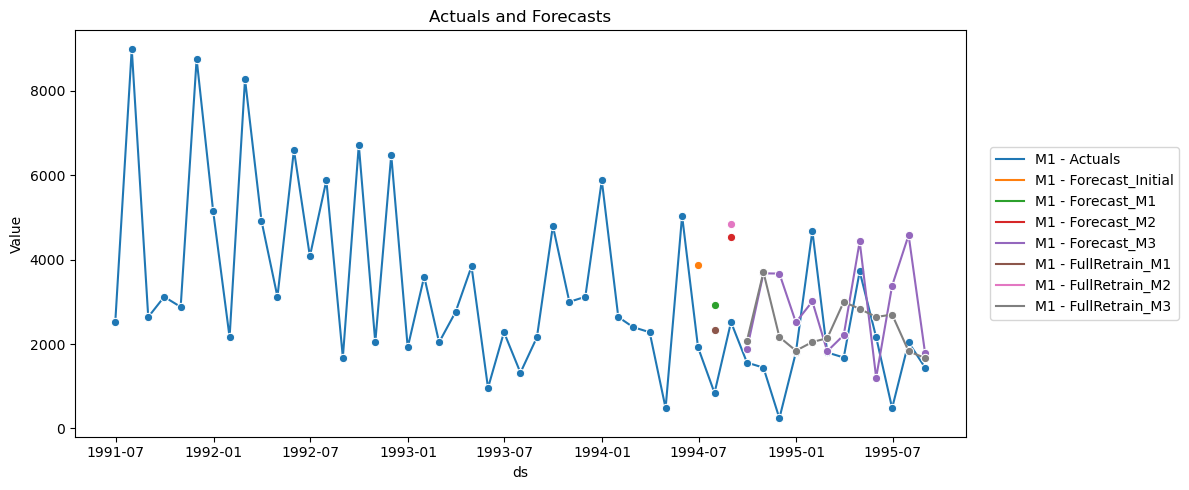

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

UNIQUE_ID = "M1"

def melt(df, col, label):
    d = df[['unique_id','ds',col]].rename(columns={col:'Value'})
    d['Source'] = label
    return d

def norm(df, name):
    col = [c for c in df.columns if c not in ['unique_id','ds','y']][-1]
    return df.rename(columns={col:name})[['unique_id','ds',name]]

frames = [
    ("Forecast_Initial",  predictions_month_zero.head(1)),
    ("Forecast_M1",       predictions_month_one.head(1)),
    ("Forecast_M2",       predictions_month_two.head(1)),
    ("Forecast_M3",       predictions_month_three),       
    ("FullRetrain_M1",    full_retrain_one.head(1)),
    ("FullRetrain_M2",    full_retrain_two.head(1)),
    ("FullRetrain_M3",    full_retrain_three),             
]

# Actuals
combined = data[['unique_id','ds','y']].rename(columns={'y':'Value'})
combined['Source'] = "Actuals"

# Add all forecasts
for name, df in frames:
    if df is not None and not df.empty:
        nd = norm(df, name)
        combined = pd.concat([combined, melt(nd, name, name)], ignore_index=True)

combined['ds'] = pd.to_datetime(combined['ds'])
combined = combined[combined['unique_id']==UNIQUE_ID]
combined['label'] = combined['unique_id'] + " - " + combined['Source']

plt.figure(figsize=(12,5))
sns.lineplot(data=combined, x='ds', y='Value', hue='label',
             marker='o', estimator=None, palette='tab10', linewidth=1.5)
plt.title("Actuals and Forecasts")
plt.legend(title='', loc='center left', bbox_to_anchor=(1.02,0.5))
plt.tight_layout()
plt.show()





## **Comparative analysis of Incremental Updates and Full Retraining**

The plots and RMSE comparison table together provide a complete picture of how the two forecasting strategies behave as new data becomes available. Both methods process the same series, but their update mechanisms differ. Incremental forecasting updates only the data window while preserving the learned model parameters. Full retraining rebuilds the entire model on each expanded dataset. The following points summarise the observed behaviour.

#### 1. **Responsiveness to new observations**

* Incremental updates shift the forecasts quickly toward the newest actual points. This is visible in the plot where each successive update pulls the forecast curves closer to the recent downward and upward movements in Month 1, 2 and 3.
* Full retraining is also responsive, but sometimes overshoots or undershoots depending on how the newly retrained model interprets the expanded historical window. The variance introduced in the retrained curves is visible in the colour coded lines for FullRetrain M1, M2 and M3.

#### 2. **Stability and continuity of the forecast path**

* The incremental method produces smoother transitions, since the model parameters do not change. Only the lagged features derived from the newly appended data shift the forecasts. This preserves the character of the initial model and avoids abrupt structural changes.
* Full retraining reoptimises the model with every cycle. This can cause sudden changes in the shape of the predictions.

#### 3. **Accuracy across the three cycles**

* For Month One and Month Two, the incremental approach produces lower MAE and RMSE than the retrained model. This suggests that the original model was already well tuned and preserving its parameters provided better generalisation.
* For Month Three, the trend reverses and the fully retrained model performs better. This indicates that by the third update the model benefits from incorporating the longer training history and reoptimising its parameters.

#### 4. **Practical interpretation**

* Incremental forecasting is more stable, less computationally heavy and adapts quickly to new information. It is suitable for real time or high frequency update environments.
* Full retraining can provide benefits once enough new data accumulates, especially if the underlying pattern has shifted. However, it is more sensitive to small data variations and may introduce unnecessary volatility when used too frequently.



## **Conclusion**

This tutorial shows that incremental forecasting with MLForecast provides a practical and efficient way to manage evolving time series. By combining lag based feature engineering with `update()` mechanisms, the approach keeps forecasts aligned with incoming data while avoiding the cost of frequent full model rebuilds. The results highlight how incremental updates maintain stability and continuity, making them suitable for production settings where new observations arrive regularly. Full retraining still has value when enough new information accumulates, but incremental updates offer a reliable and scalable foundation for ongoing forecasting operations.

## **References**

1. Nixtla Team. (2024). *MLForecast: Scalable Machine Learning for Time Series Forecasting.*  
   Available at: [https://nixtlaverse.nixtla.io/mlforecast](https://nixtlaverse.nixtla.io/mlforecast)

2. Makridakis, S., & Hibon, M. (2000). *The M3-Competition: Results, Conclusions and Implications.*  
   *International Journal of Forecasting*, 16(4), 451–476.  
   DOI: [10.1016/S0169-2070(00)00057-1](https://doi.org/10.1016/S0169-2070(00)00057-1)

3. A Practical Guide to Incremental Updates and Transfer Learning for Scalable New-Product Forecasting using MLForecast by Satyajit Chaudhuri. Available at: [Medium](https://medium.com/gitconnected/a-practical-guide-to-incremental-updates-and-transfer-learning-for-scalable-new-product-forecasting-b0c3916ebf78)